In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# 🌐 os: For interacting with the operating system, like working with file paths and directories
import os

# 📁 shutil: For copying, moving, or deleting files and directories
import shutil

# 🔢 numpy: For handling numerical operations and arrays (used here for data manipulation)
import numpy as np

# 📊 matplotlib.pyplot: For plotting graphs like accuracy/loss curves to visualize model performance
import matplotlib.pyplot as plt

# 🔄 train_test_split: For splitting datasets into training and validation sets randomly
from sklearn.model_selection import train_test_split

# 🤖 tensorflow: The main machine learning library we're using to build and train deep learning models
import tensorflow as tf

# 🧰 ImageDataGenerator: For loading images and applying real-time data augmentation (like flipping or rotating)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🏗️ layers: To build the layers of the neural network (like Dense, Dropout, etc.)
# 🏗️ models: To define and compile the overall neural network model
from tensorflow.keras import layers, models

In [ ]:
# Set parameters

# Path to the dataset (CATEGORY A inside Google Drive)
DATA_DIR = '/content/drive/MyDrive/image_dataset/CATEGORY A/CATA-French'

# Path to the output directory where the split (train/val) data will be stored in Colab's local storage
OUTPUT_DIR = '/content/split_data'

# Path to save the trained model back to Google Drive
MODEL_SAVE_PATH = '/content/drive/MyDrive/crop_pest_disease_classifier.keras'

# Resize all images to 224x224 pixels (standard size for many pretrained models)
IMG_SIZE = (224, 224)

# Number of images processed together in one batch during training
BATCH_SIZE = 32

# Create the output directory if it doesn't already exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Debugging cell
os.listdir('/content/drive/MyDrive')

['Getting started.pdf', 'TOM2024.zip', 'image_dataset']

In [ ]:
import glob

In [ ]:
def split_data(data_dir, output_dir, val_size=0.2):
    """
    Split the dataset into training and validation sets while preserving folder structure.
    """
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    print("📁 Starting data split...")

    # Loop through each language folder (CATA-English, CATA-French)
    for language_folder in os.listdir(data_dir):
        language_path = os.path.join(data_dir, language_folder)

        if not os.path.isdir(language_path):
            continue  # Skip if it's not a folder

        print(f"🔍 Processing language folder: {language_folder}")

        # Loop through each class (onion_diseases, maize_pests, etc.)
        for class_name in os.listdir(language_path):
            class_folder = os.path.join(language_path, class_name)

            if not os.path.isdir(class_folder):
                continue  # Skip if it's not a folder

            print(f"  ➡️ Class: {class_name}")

            # ✅ Recursively get all image paths from subfolders
            image_paths = glob.glob(os.path.join(class_folder, '**', '*.*'), recursive=True)
            image_paths = [path for path in image_paths if path.lower().endswith(('.png', '.jpg', '.jpeg'))]

            print(f"    Found {len(image_paths)} images.")

            if len(image_paths) == 0:
                print(f"    ⚠️ No images found for {class_name}. Skipping...")
                continue  # Skip this class if no images are found

            # Split into training and validation sets
            train_paths, val_paths = train_test_split(image_paths, test_size=val_size, random_state=42)

            # Create corresponding folders in train and val directories
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

            # Copy training images
            for path in train_paths:
                shutil.copy(path, os.path.join(train_dir, class_name, os.path.basename(path)))

            # Copy validation images
            for path in val_paths:
                shutil.copy(path, os.path.join(val_dir, class_name, os.path.basename(path)))

            print(f"    ✅ {len(train_paths)} training and {len(val_paths)} validation images copied for class '{class_name}'.")

    print("✅ Data split completed!")

split_data(DATA_DIR, OUTPUT_DIR)

📁 Starting data split...
🔍 Processing language folder: onion_diseases
  ➡️ Class: Fusariose-D
    Found 738 images.
    ✅ 590 training and 148 validation images copied for class 'Fusariose-D'.
  ➡️ Class: Virose-D
    Found 203 images.
    ✅ 162 training and 41 validation images copied for class 'Virose-D'.
  ➡️ Class: Pourriture des bulbes-D
    Found 30 images.
    ✅ 24 training and 6 validation images copied for class 'Pourriture des bulbes-D'.
  ➡️ Class: Feuille saine
    Found 679 images.
    ✅ 543 training and 136 validation images copied for class 'Feuille saine'.
  ➡️ Class: Alternariose_D
    Found 515 images.
    ✅ 412 training and 103 validation images copied for class 'Alternariose_D'.
🔍 Processing language folder: tomato_pests
  ➡️ Class: tuta_absoluta_p
    Found 19 images.
    ✅ 15 training and 4 validation images copied for class 'tuta_absoluta_p'.
  ➡️ Class: helicoverpa_armigera_p
    Found 298 images.
    ✅ 238 training and 60 validation images copied for class 'hel

In [ ]:
# Step 2: Create ImageDataGenerators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to [0,1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Step 3: Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    os.path.join(OUTPUT_DIR, 'train'),  # Updated with the split data path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # 'categorical' because we have multiple classes
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(OUTPUT_DIR, 'val'),  # Updated with the split data path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9799 images belonging to 28 classes.
Found 2461 images belonging to 28 classes.


In [ ]:
# Step 4: Build the Model using EfficientNetB0 for transfer learning
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base model layers

# Build the model on top of EfficientNetB0
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 5: Train model with progress
print("🚀 Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
print("🎉 Training completed!")

🚀 Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
306/306 ━━━━━━━━━━━━━━━━━━━━ 1098s 4s/step - accuracy: 0.1525 - loss: 2.8479 - val_accuracy: 0.1785 - val_loss: 2.7856
Epoch 2/2
  1/306 ━━━━━━━━━━━━━━━━━━━━ 28:00 6s/step - accuracy: 0.1875 - loss: 2.7499

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


306/306 ━━━━━━━━━━━━━━━━━━━━ 205s 656ms/step - accuracy: 0.1875 - loss: 2.7499 - val_accuracy: 0.1768 - val_loss: 2.7799
🎉 Training completed!


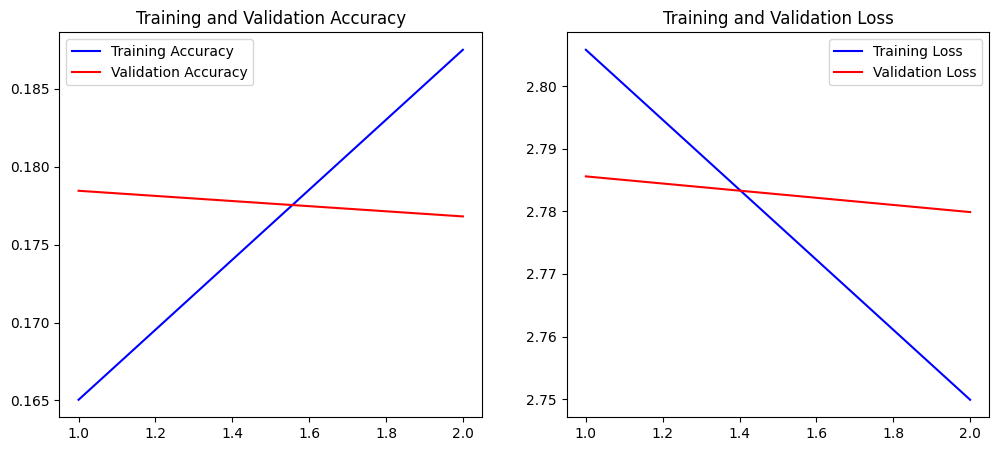

In [ ]:
# Step 6: Plot accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
# Step 7: Save model to Google Drive
print(f"💾 Saving model to {MODEL_SAVE_PATH}")
model.save(MODEL_SAVE_PATH)
print("✅ Model saved!")

💾 Saving model to /content/drive/MyDrive/crop_pest_disease_classifier.keras
✅ Model saved!
